In [1]:
%matplotlib inline

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import nlp
import random

In [2]:
#Setup and Imports
def show_history(h):
    epochs_trained = len(h.history['loss'])
    plt.figure(figsize=(16, 6))

    plt.subplot(1, 2, 1)
    plt.plot(range(0, epochs_trained), h.history.get('accuracy'), label='Training')
    plt.plot(range(0, epochs_trained), h.history.get('val_accuracy'), label='Validation')
    plt.ylim([0., 1.])
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(range(0, epochs_trained), h.history.get('loss'), label='Training')
    plt.plot(range(0, epochs_trained), h.history.get('val_loss'), label='Validation')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

    
def show_confusion_matrix(y_true, y_pred, classes):
    from sklearn.metrics import confusion_matrix
    
    cm = confusion_matrix(y_true, y_pred, normalize='true')

    plt.figure(figsize=(8, 8))
    sp = plt.subplot(1, 1, 1)
    ctx = sp.matshow(cm)
    plt.xticks(list(range(0, 6)), labels=classes)
    plt.yticks(list(range(0, 6)), labels=classes)
    plt.colorbar(ctx)
    plt.show()

    
print('Using TensorFlow version', tf.__version__)

Using TensorFlow version 2.3.0


In [3]:
#Importing Data
dataset = nlp.load_dataset('emotion')


Using custom data configuration default


In [4]:

train = dataset['train']
val = dataset['validation']
test = dataset['test']

In [5]:
def get_tweet(data):
  tweets = [x['text'] for x in data]
  labels = [x['label'] for x in data]
  return tweets, labels


tweets, labels = get_tweet(train)

In [6]:
tweets[0], labels[0]

('i didnt feel humiliated', 'sadness')

In [7]:
### Task 4: Tokenizer
from tensorflow.keras.preprocessing.text import Tokenizer

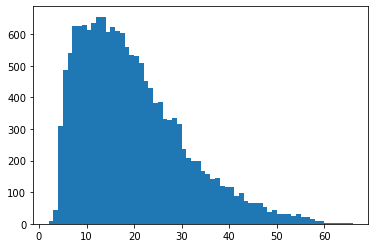

In [8]:
tokenizer = Tokenizer(num_words=10000, oov_token='<UNK>')
tokenizer.fit_on_texts(tweets)


lengths = [len(t.split(' ')) for t in tweets]
plt.hist(lengths, bins = len(set(lengths)))
plt.show()

In [9]:
import pickle



In [11]:
def set_tokenizer(tokenizer):
    # saving
    with open('tokenizer.pickle', 'wb') as handle:
        pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

def get_tokenizer():
    # loading
    with open('tokenizer.pickle', 'rb') as handle:
        tokenizer = pickle.load(handle)
    return tokenizer

In [12]:
set_tokenizer(tokenizer)

In [12]:
#Padding and Truncating Sequences

maxlen = 50

from tensorflow.keras.preprocessing.sequence import pad_sequences

In [13]:
def get_sequences(tokenizer, tweets):
  sequences = tokenizer.texts_to_sequences(tweets)
  padded = pad_sequences(sequences, maxlen=maxlen, truncating='post', 
                         padding='post')
  return padded

padded_train_seq = get_sequences(tokenizer, tweets)

padded_train_seq[0]

array([  2, 139,   3, 679,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0])

{'love', 'surprise', 'joy', 'fear', 'sadness', 'anger'}


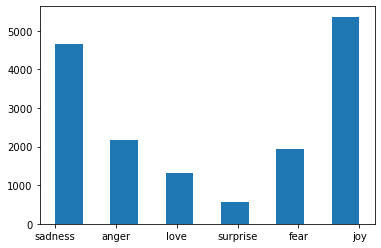

4


In [17]:
##Preparing the Labels

classes = set(labels)
print(classes)

plt.hist(labels, bins = 11)
plt.show()

class_to_index = dict((c, i) for i, c in enumerate(classes))
index_to_class = dict((v, k) for k, v in class_to_index.items())

class_to_index

index_to_class

names_to_ids = lambda labels: np.array([class_to_index.get(x) for x in labels])

train_labels = names_to_ids(labels)
print(train_labels[0])

class label_classes:
    def __init__(self, c_to_i, i_to_c):
        self.class_to_index = c_to_i
        self.index_to_class = i_to_c
        
label_class =   label_classes(class_to_index, index_to_class)  

with open('class_to_index1.pickle', 'wb') as handle:
        pickle.dump(class_to_index, handle, protocol=pickle.HIGHEST_PROTOCOL)
        
with open('index_to_class1.pickle', 'wb') as handle:
    pickle.dump(index_to_class, handle, protocol=pickle.HIGHEST_PROTOCOL)
    

In [15]:
#Creating the Model

model = tf.keras.models.Sequential([
        tf.keras.layers.Embedding(10000, 16, input_length=maxlen),
        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(20, return_sequences= True)),
        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(20)),
        tf.keras.layers.Dense(6, activation='softmax')
])

In [16]:
model.compile(
    loss = 'sparse_categorical_crossentropy',
    optimizer = 'adam',
    metrics = ['accuracy']
)

In [17]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 50, 16)            160000    
_________________________________________________________________
bidirectional (Bidirectional (None, 50, 40)            5920      
_________________________________________________________________
bidirectional_1 (Bidirection (None, 40)                9760      
_________________________________________________________________
dense (Dense)                (None, 6)                 246       
Total params: 175,926
Trainable params: 175,926
Non-trainable params: 0
_________________________________________________________________


In [18]:
#Training the Model 

val_tweets, val_labels = get_tweet(val)
val_seq = get_sequences(tokenizer, val_tweets)
val_labels = names_to_ids(val_labels)

val_tweets[0], val_labels[0]

('im feeling quite sad and sorry for myself but ill snap out of it soon', 0)

In [19]:
h = model.fit(
    padded_train_seq, train_labels,
    validation_data = (val_seq, val_labels),
    epochs = 20,
    callbacks = [
                 tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=2)
    ]
)

Epoch 1/20
500/500 [==============================] - 21s 42ms/step - loss: 1.3215 - accuracy: 0.4849 - val_loss: 0.7887 - val_accuracy: 0.7105
Epoch 2/20
500/500 [==============================] - 18s 35ms/step - loss: 0.5502 - accuracy: 0.8023 - val_loss: 0.5167 - val_accuracy: 0.8375
Epoch 3/20
500/500 [==============================] - 18s 36ms/step - loss: 0.2750 - accuracy: 0.9130 - val_loss: 0.3762 - val_accuracy: 0.8795
Epoch 4/20
500/500 [==============================] - 19s 38ms/step - loss: 0.1620 - accuracy: 0.9492 - val_loss: 0.3552 - val_accuracy: 0.8915
Epoch 5/20
500/500 [==============================] - 19s 37ms/step - loss: 0.1251 - accuracy: 0.9595 - val_loss: 0.3565 - val_accuracy: 0.8945
Epoch 6/20
500/500 [==============================] - 19s 37ms/step - loss: 0.0924 - accuracy: 0.9711 - val_loss: 0.3610 - val_accuracy: 0.8940
Epoch 7/20
500/500 [==============================] - 20s 39ms/step - loss: 0.0756 - accuracy: 0.9768 - val_loss: 0.3989 - val_accuracy:

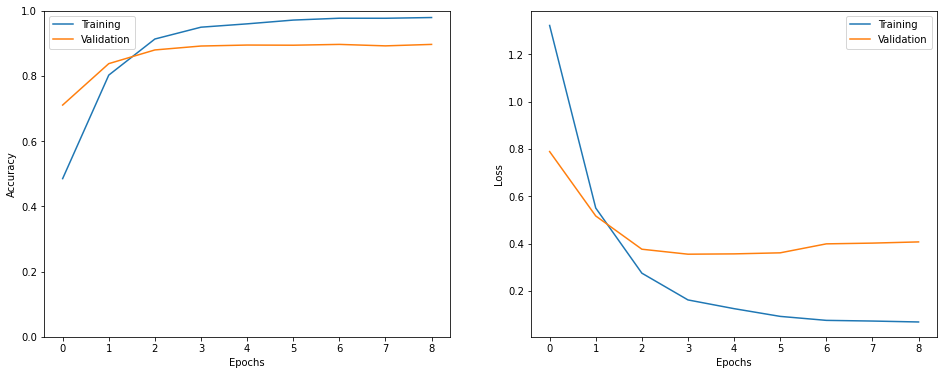

In [20]:
#Evaluating the Model


show_history(h)

In [21]:
test_tweets, test_labels = get_tweet(test)
test_seq = get_sequences(tokenizer, test_tweets)
test_labels = names_to_ids(test_labels)

63/63 [==============================] - 1s 14ms/step - loss: 0.4299 - accuracy: 0.8855
Sentence :  i feel like im still quite bad at describing my feelings with good words and beautiful phrases
Emotion :  sadness
Predicted emtion :  joy
Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).


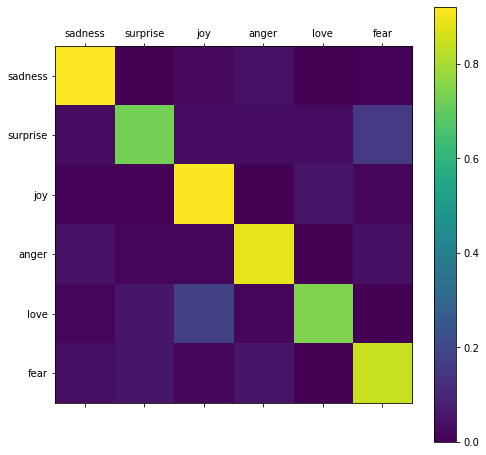

In [22]:
_ = model.evaluate(test_seq, test_labels)


i = random.randint(0, len(test_labels) - 1)
print('Sentence : ', test_tweets[i])
print('Emotion : ', index_to_class[test_labels[i]])

p = model.predict(np.expand_dims(test_seq[i], axis=0))[0]
pred_class = index_to_class[np.argmax(p).astype('uint8')]

print('Predicted emtion : ', pred_class)

preds = model.predict_classes(test_seq)

show_confusion_matrix(test_labels, preds, list(classes))

In [23]:
model.save('model/my_model')

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: model/my_model\assets
